In [1]:
%%capture
%run 02_FeatEng.ipynb

In [2]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error  as skl_mse

In [3]:
import mle.tsa as mle_tsa

Importing plotly failed. Interactive plots will not work.


In [4]:
import shap 
shap.initjs()

# Split Data

In [123]:
all_features = curr_features + seas_features + extra_features
target = 'cons_GNA95_pct_change1_t1'

In [124]:
x_train = data_train[all_features].copy()
y_train = data_train[target].copy()

In [126]:
x_test = data_test[all_features].copy()
y_test = data_test[target].copy()

In [127]:
tscv = TimeSeriesSplit(n_splits=3)

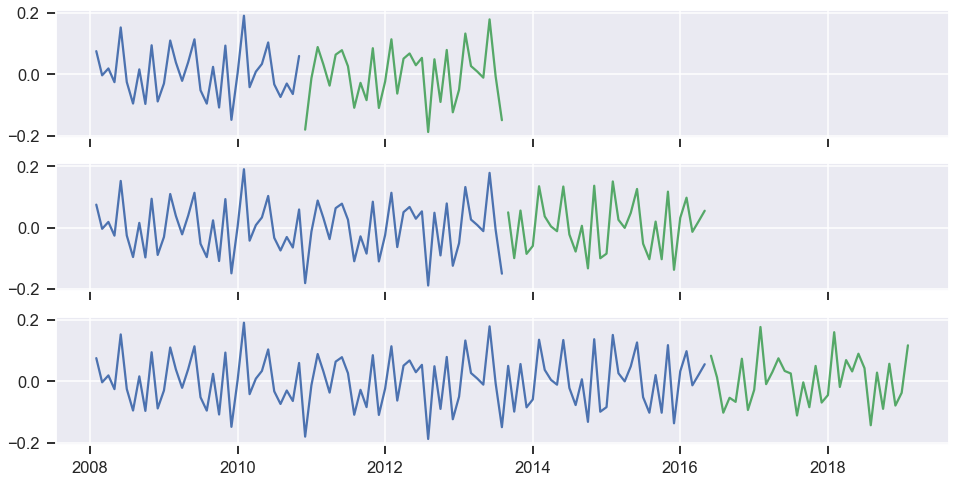

In [128]:
fig, axs = plt.subplots(3,1, sharex=True)

for i, (train_index, val_index) in enumerate(tscv.split(y_train)):
    axs[i].plot(y_train[train_index],label='train')
    axs[i].plot(y_train[val_index],label='valid')

# Model Building

In [129]:
rf  = RandomForestRegressor(criterion='mse', n_estimators=100, bootstrap=True, oob_score=True, ccp_alpha=0,
                            min_samples_leaf=3,
                            n_jobs=-1, random_state=123)

In [130]:
rf_hparams_grid = {'max_depth': [2, 4],
                    'max_features': [0.5, 0.75]}
rf_cv = GridSearchCV(rf, rf_hparams_grid, scoring='neg_mean_squared_error', n_jobs=-1, cv=tscv, refit=True, return_train_score=True)
rf_cv_res = rf_cv.fit(x_train, y_train)

In [131]:
rf_cv_res_df = pd.DataFrame(rf_cv_res.cv_results_)

In [132]:
rf_cv_mod = rf_cv_res.best_estimator_

In [133]:
rf_cv_mod

RandomForestRegressor(bootstrap=True, ccp_alpha=0, criterion='mse', max_depth=4,
                      max_features=0.75, max_leaf_nodes=None, max_samples=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                      oob_score=True, random_state=123, verbose=0,
                      warm_start=False)

In [134]:
rf_cv_res.best_score_

-0.0031288606157431637

## Prediction and Forecating

In [135]:
p_gna95_train = pd.Series(index=data_train.index, data=rf_cv_mod.predict(x_train))
p_gna95_test = pd.Series(index=data_test.index, data=rf_cv_mod.predict(x_test))

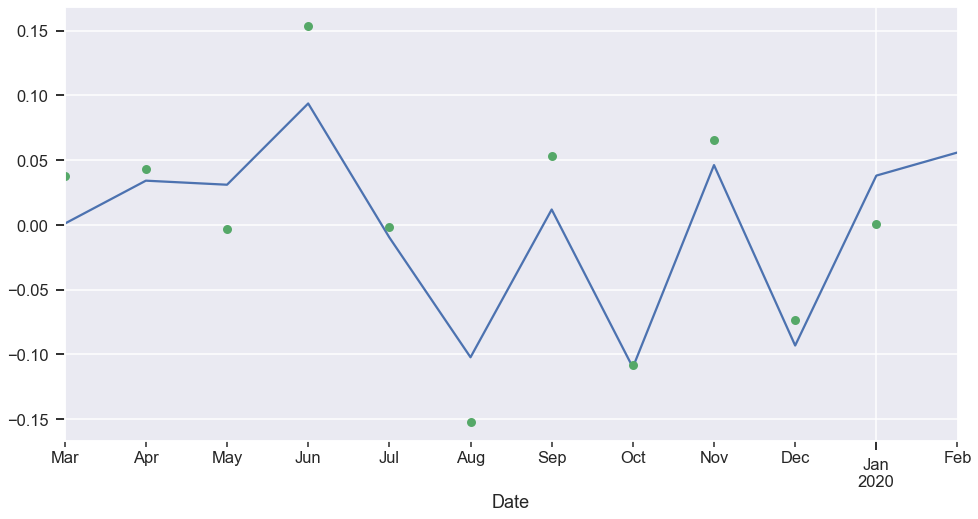

In [136]:
ax = p_gna95_test.plot()
y_test.plot(label='actual', style='o', ax=ax)
plt.show()

In [137]:
p_gna95_train_df = p_gna95_train.to_frame("p_cons_GNA95_pct_change1_t1")
p_gna95_train_df['cons_GNA95'] = data_train['cons_GNA95']

p_gna95_test_df = p_gna95_test.to_frame("p_cons_GNA95_pct_change1_t1")
p_gna95_test_df['cons_GNA95'] = data_test['cons_GNA95']

p_gna95_train_df['split'] = 'train'
p_gna95_test_df['split'] = 'test'

p_gna95_df = pd.concat([p_gna95_train_df, p_gna95_test_df], axis=0)

In [138]:
p1_s = pd.Series(index=p_gna95_df.index, dtype=np.number)
p0 = p_gna95_df['cons_GNA95'].iloc[0]

for idx, row in p_gna95_df.iterrows():
    p1 = (row['p_cons_GNA95_pct_change1_t1'] * p0 + p0)
    p0 =  p_gna95_df.loc[idx,'cons_GNA95']  # Using true value, carefully verify this assumption in your workflow
    p1_s[idx] = p1


In [139]:
p_gna95_df['cons_GNA95_t1'] = p_gna95_df['cons_GNA95'].shift(-1)
p_gna95_df["p_cons_GNA95_t1"] = p1_s
# Adatp to forecasting models time-frame
p_gna95_df["p_cons_GNA95"] = p_gna95_df["p_cons_GNA95_t1"].shift(1)
p_gna95_df = p_gna95_df.iloc[1:].copy()

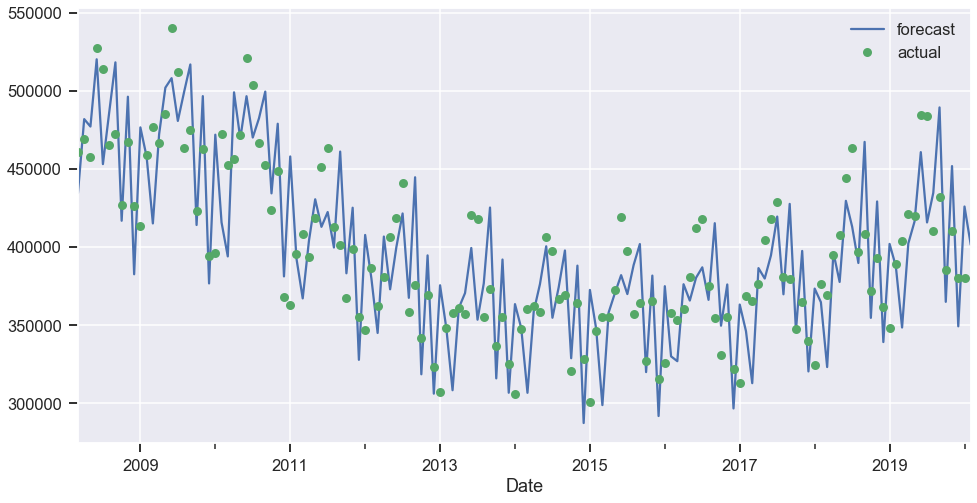

In [140]:
fig, ax = plt.subplots(1,1)
p_gna95_df.plot(y = 'p_cons_GNA95_t1', label='forecast', ax=ax)
p_gna95_df.plot(y = 'cons_GNA95_t1', label='actual', style='o', ax=ax)
plt.show()

# Model Interpretation

## Global feature importance
* Measures how important a feature is in overal model performance
* scikit-learn out-of-the box global feature imoprtance does not inform about relationship direction

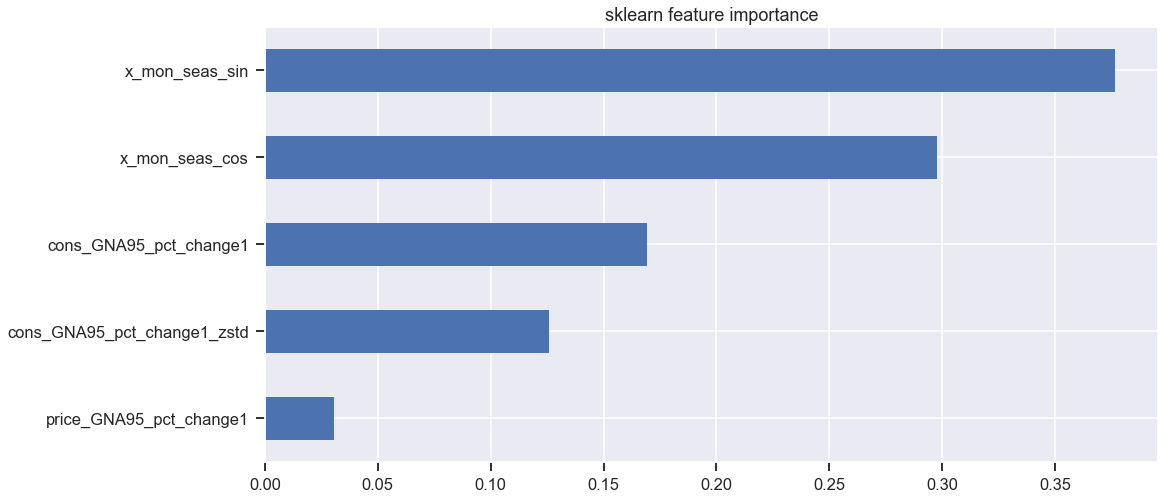

In [141]:
sklearn_fi = pd.Series(index=all_features, data=rf_cv_mod.feature_importances_).sort_values(ascending=True)
sklearn_fi.plot.barh()
plt.title('sklearn feature importance')
plt.show()

## SHAP values

In [142]:
explainer_model1 = shap.TreeExplainer(rf_cv_mod, feature_perturbation ='tree_path_dependent')
shap_values1 = explainer_model1.shap_values(x_train)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [143]:
explainer_model2 = shap.TreeExplainer(rf_cv_mod, data =x_train)
shap_values2 = explainer_model2.shap_values(x_train)

In [144]:
print('Expected base value in shap algorithm: ', explainer_model1.expected_value)
print('Expected base value in shap algo, fit with data: ', explainer_model2.expected_value)
print('Target mean: ', y_train.mean())
print('Model prediction mean: ', p_gna95_train.mean())

Expected base value in shap algorithm:  [0.00362906]
Expected base value in shap algo, fit with data:  0.0021186278617258618
Target mean:  0.002723530319090796
Model prediction mean:  0.002118627861725858


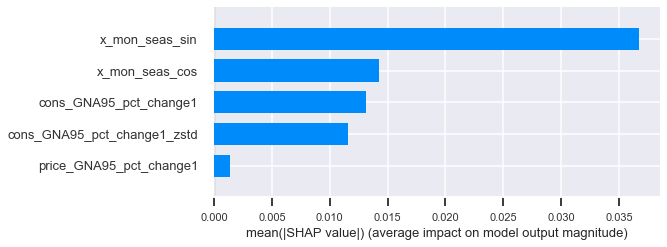

In [145]:
shap.summary_plot(shap_values2, x_train, plot_type="bar")

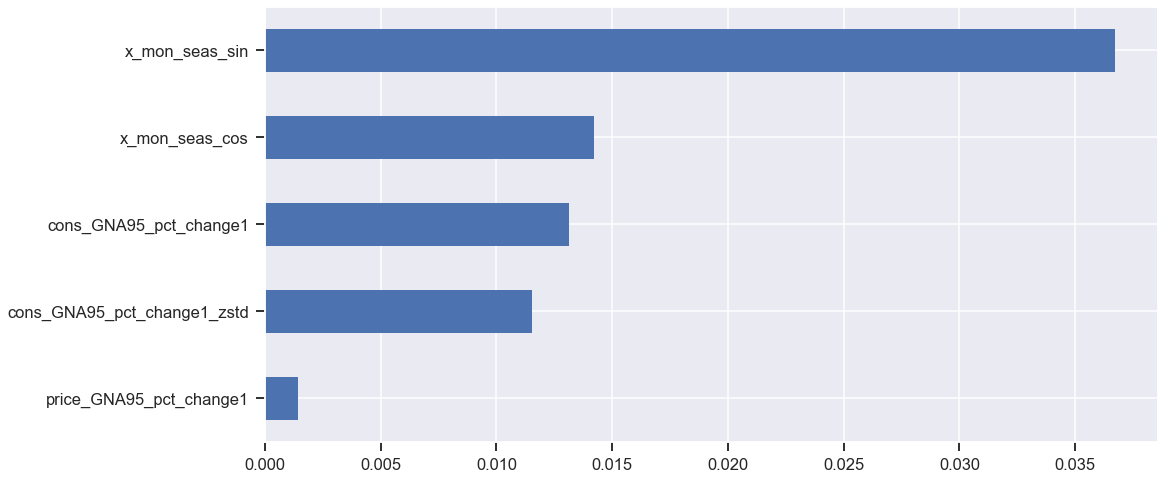

In [146]:
pd.Series(index=all_features, data=abs(shap_values2).mean(axis=0)).sort_values().plot.barh()
plt.show()

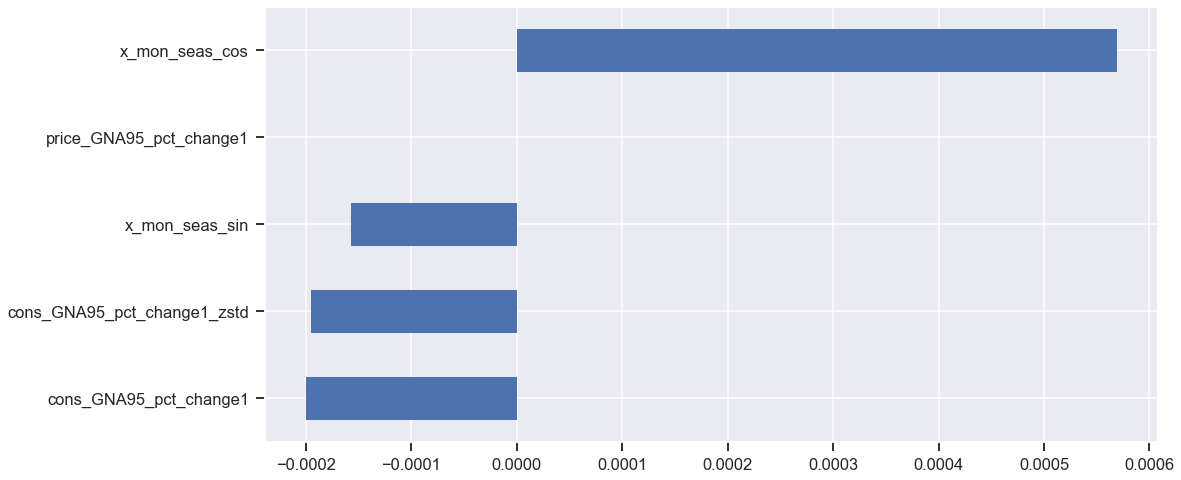

In [147]:
pd.Series(index=all_features, data=shap_values2.mean(axis=0)).sort_values().plot.barh()
plt.show()

## Local Feature Importance

In [148]:
shap.force_plot(explainer_model2.expected_value, shap_values2[3], x_train.iloc[[3]], figsize =(16,4))

In [149]:
def shap_force_plot(base_value,  shap_values, features_data, obs_j):
    features_names = features_data.columns.tolist()
    shap_values_row = shap_values[obs_j]
    features_row = features_data.iloc[obs_j]
    shap_vals_j = pd.Series(index=features_names, data=shap_values_row).to_frame('raw shap values j')
    shap_vals_j['shap values j'] = shap_vals_j['raw shap values j'] + base_value
    shap_vals_j['contrib to base value'] = np.where(shap_vals_j['raw shap values j']>0, 'positive', 'negative')
    ax = sns.barplot(data=shap_vals_j, x='raw shap values j', y=features_names, hue='contrib to base value')
    plt.title('Force plot: Shap contribution to prediction by feature')
    return ax

In [150]:
shap_values_df = pd.DataFrame(index=x_train.index, data=shap_values2, columns=all_features)
shap_values_df

,cons_GNA95_pct_change1,price_GNA95_pct_change1,x_mon_seas_cos,x_mon_seas_sin,cons_GNA95_pct_change1_zstd
Date,,,,,
2008-02-01,0.013660,-0.001156,0.009114,0.031457,0.010555
2008-03-01,-0.012791,-0.000659,0.010649,0.029966,-0.017807
2008-04-01,0.002326,-0.000280,0.000010,0.031672,0.006980
2008-05-01,-0.002555,0.000199,0.005979,0.026827,0.003383
2008-06-01,0.015506,0.001914,0.045181,0.030813,0.012603
...,...,...,...,...,...
2018-10-01,-0.011733,-0.001480,0.002240,-0.095040,-0.002696
2018-11-01,0.013267,0.002996,-0.000831,0.023834,0.009898
2018-12-01,-0.015617,0.002624,-0.073920,0.013183,-0.015553


## Detailed Analysis: z-std pct changes in consumption influence
z_std measures a shudden and important change in consumption, in general, it is less important than other features like seasonality, but can be a main driver forecast in some extreme situtations?

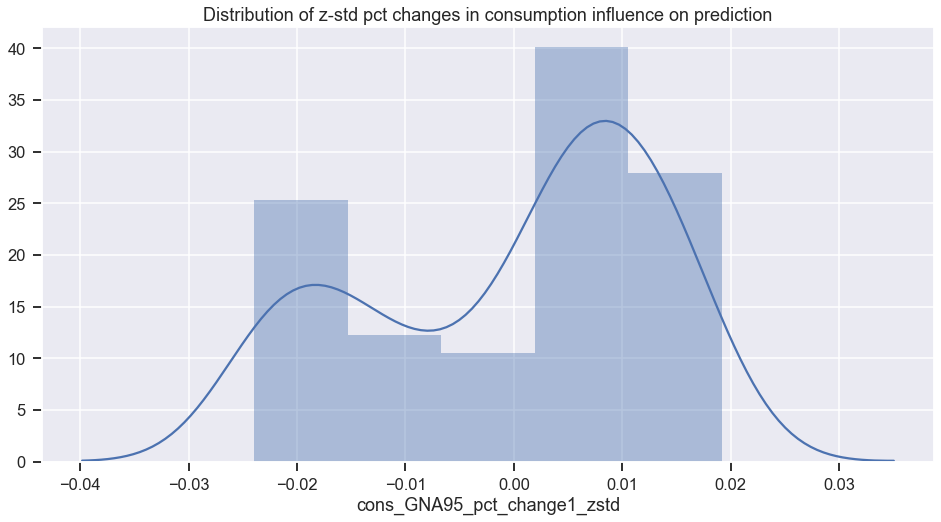

In [189]:
sns.distplot(shap_values_df['cons_GNA95_pct_change1_zstd'])
plt.title("Distribution of z-std pct changes in consumption influence on prediction")
plt.show()

In [190]:
most_imp_feat_by_obs = abs(shap_values_df).idxmax(axis=1)

In [192]:
mask = most_imp_feat_by_obs[most_imp_feat_by_obs == 'cons_GNA95_pct_change1_zstd'] 
p_gna95_df.loc[mask.index]

,p_cons_GNA95_pct_change1_t1,cons_GNA95,split,cons_GNA95_t1,p_cons_GNA95_t1,p_cons_GNA95
Date,,,,,,
2008-07-01,-0.009481,527496.527424,train,514234.767077,453229.951047,520341.867221
2013-07-01,-0.009481,420950.070000,train,418173.030000,353622.333471,399549.526169
2014-07-01,-0.009484,406491.630000,train,397692.920000,354877.992674,400624.583112


In [193]:
idx = range(len(most_imp_feat_by_obs))
dates = most_imp_feat_by_obs.index.strftime('%Y-%m-%d')
dt_to_idx = dict(zip(dates, idx))

In [202]:
date_obs = '2013-07-01'
idx_obs = dt_to_idx[date_obs]
shap.force_plot(explainer_model2.expected_value, shap_values2[idx_obs], x_train.iloc[[idx_obs]], figsize =(16,4))

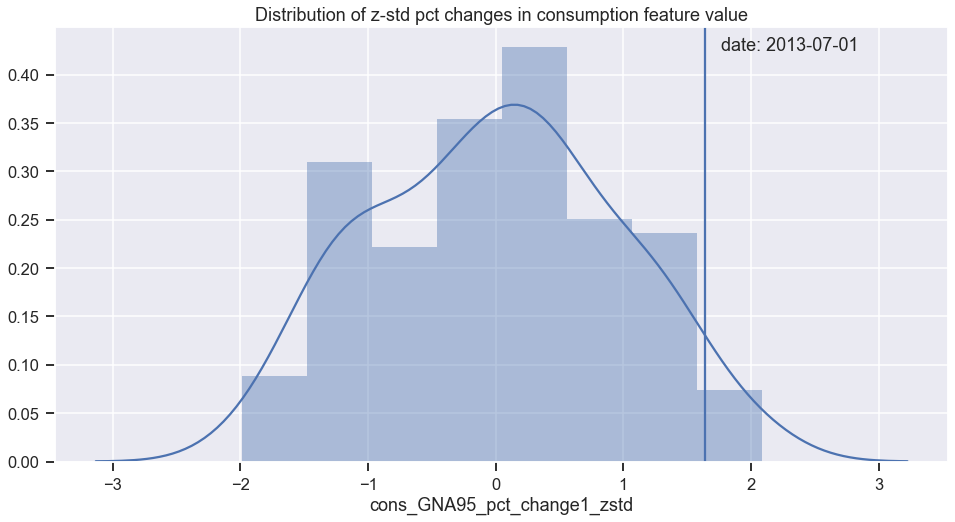

In [208]:
x_feat_value = x_train.loc[date_obs, 'cons_GNA95_pct_change1_zstd']
sns.distplot(x_train['cons_GNA95_pct_change1_zstd'])
plt.title("Distribution of z-std pct changes in consumption feature value")
plt.axvline(x_feat_value)
plt.text(0.80, 0.95, f'date: {date_obs}', ha='right', va='top', transform = ax.transAxes)
plt.show()

In targeted, pct change in consumptions experiments a tail value (in z_std scale), this leads the model to a prediction where this feature is the MOST IMPORTANT CONTRIBUTOR. In addition, this contribution leads the prediction really close to true value

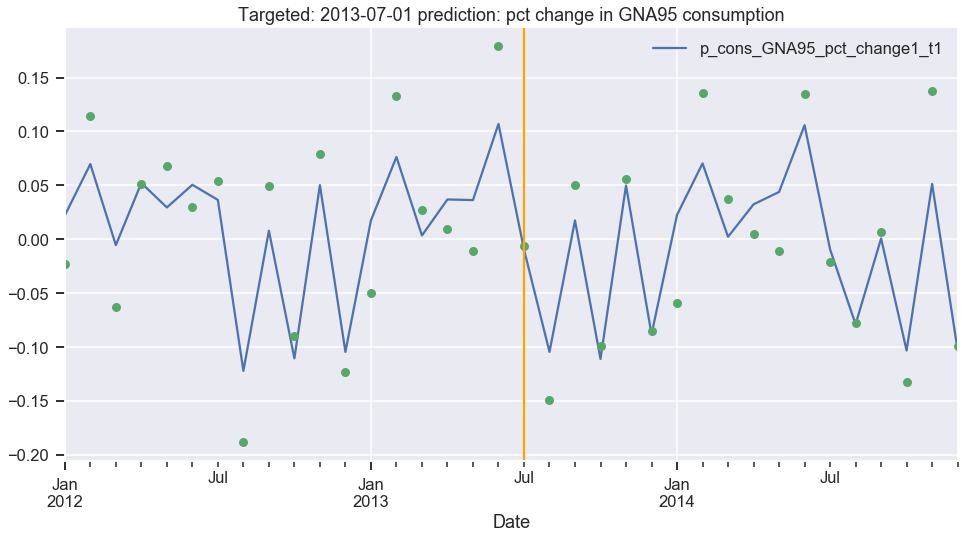

In [195]:
zoom_yr = int(date_obs[:4])
ax = p_gna95_train_df['2012':'2014'].plot(y='p_cons_GNA95_pct_change1_t1')
y_train['2012':'2014'].plot(y='cons_GNA95_pct_change1_t1', style='o', ax=ax)
plt.axvline(date_obs, color='orange')
plt.title(f"Targeted: {date_obs} prediction: pct change in GNA95 consumption")
plt.show()

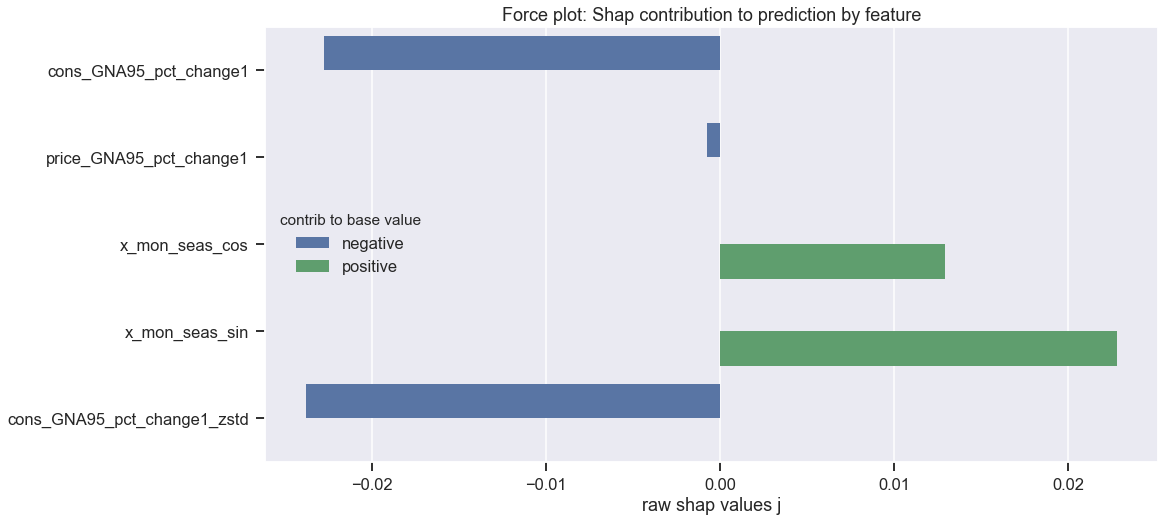

In [209]:
ax = shap_force_plot(base_value=explainer_model2.expected_value,  shap_values=shap_values2, features_data=x_train, obs_j=idx_obs)
plt.show()

In [213]:
x_train.iloc[idx_obs:idx_obs+1].T

Date,2013-07-01
cons_GNA95_pct_change1,0.179108
price_GNA95_pct_change1,0.018323
x_mon_seas_cos,-0.866025
x_mon_seas_sin,-0.500000
cons_GNA95_pct_change1_zstd,1.639536


# Benchmark

In [214]:
mask_test = p_gna95_df['split'] == 'test'
skl_mse(p_gna95_df.loc[mask_test, 'cons_GNA95'], p_gna95_df.loc[mask_test, 'p_cons_GNA95'])**0.5

38384.44188300434

In [215]:
mask_test = p_gna95_df['split'] == 'test'
mle_tsa.compute_ape(p_gna95_df.loc[mask_test, 'cons_GNA95'], p_gna95_df.loc[mask_test, 'p_cons_GNA95']).mean()

0.07752775692534686

In [216]:
select_cols = ['model', 'split', 'cons_GNA95', 'p_cons_GNA95']

p_gna95_df['model'] = 'simple_random_forest'
p_gna95_df[select_cols].to_excel(OUTPATH + OUTFILE, index_label='Date')